In [1]:
#!pip install pillow
#!conda install Image
#!conda install -y pillow
#!conda install -y tqdm
#!conda install -y tensorflow
#!conda install -y keras
#!conda install -y theano
#!pip install Augmentor

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#import Augmentor
from tqdm import tqdm, tqdm_notebook, tnrange

print("Note that Kaggle's directory already includes all the files. This is a list of directories in the system.")
print(os.listdir("./input"))

import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda

from skimage.transform import resize
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Input, Concatenate
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Note that Kaggle's directory already includes all the files. This is a list of directories in the system.
['train', 'test.zip', 'images', 'train.zip', 'train.csv', 'depths.csv', 'sample_submission.csv']


Using TensorFlow backend.


## Visualizing Data

Let us plot the first few images to see how our data looks like.


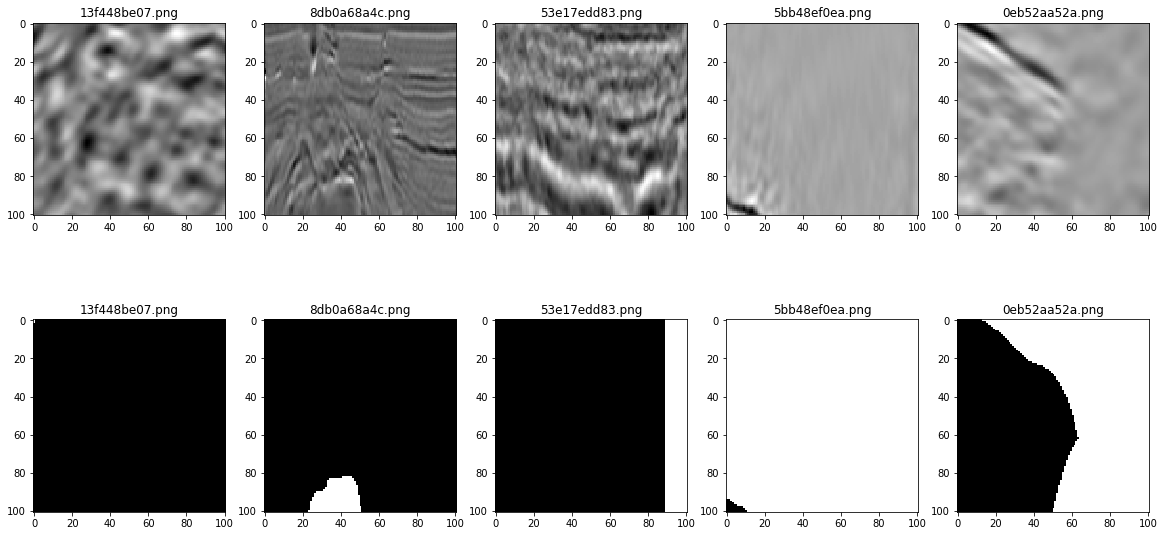

In [6]:
#setting  training paths and test paths
path_train = "./input/train"
path_test = "./input/test"

training_images = path_train + "/images"
training_masks = path_train + "/masks"


############### Visualizing data ###############
print("Let us plot the first few images to see how our data looks like.")

sample_length = 5
id_samples = os.listdir(training_images)[:sample_length]
#mask_samples = os.listdir(training_masks)[:sample_length]
#print("images: ", images)
plt.figure(figsize = (20,10))
for ix, id_ in enumerate(id_samples):
    img = load_img(training_images+ "/" + id_)
    #print("img: ", img)
    msk = load_img(training_masks + "/" + id_)
    plt.subplot(2,sample_length, ix +1)
    plt.title(id_)
    plt.imshow(img)
    plt.subplot(2,sample_length, ix+1 + sample_length)
    plt.title(id_)
    plt.imshow(msk)
plt.show()

  0%|          | 0/4000 [00:00<?, ?it/s]/home/linneu/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 4000/4000 [02:54<00:00, 22.94it/s]


Shape of X_train:  (4000, 128, 128, 1)
Shape of y_train:  (4000, 128, 128, 1)


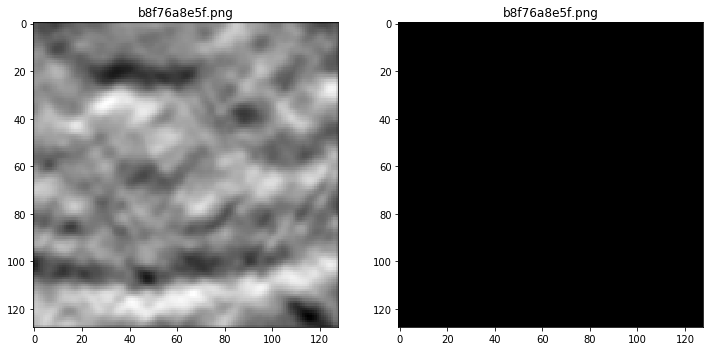

In [7]:

############## Loading images as arrays ################

#os.listdir(path_train + "/images")
# Any results you write to the current directory are saved as output.
height = 128
width = 128
chan = 1
img_width = 101
img_height = 101
img_chan = 1

all_ids = os.listdir(training_images)
X_train = np.zeros((len(all_ids), height, width, chan), dtype = np.uint8)
y_train = np.zeros((len(all_ids), height, width, 1), dtype = np.bool)
for ix, id_ in tqdm(enumerate(all_ids), total = len(all_ids)):
    #print(id_)
    #pass
    image = load_img(training_images + "/" + id_)
    mask = load_img(training_masks + "/" + id_)
    #x = img_to_array(image)[:,:,0].reshape((img_height, img_width,1))
    x = img_to_array(image)[:,:,0]
    x = resize(x, (height, width, chan), mode='constant', preserve_range=True)
    #y = img_to_array(mask)[:,:,0].reshape((img_height, img_width,1))
    y = img_to_array(mask)[:,:,0]
    y = resize(y, (height, width, 1), mode='constant', preserve_range=True)
    X_train[ix] = x
    y_train[ix] = y
#X_train = X_train/255 
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

######## Checking training set
#np.random.seed(41)
ix = np.random.randint(0,len(all_ids))
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title(all_ids[ix])
plt.imshow(X_train[ix].reshape((height, width)), cmap = "gray")
plt.subplot(1,2,2)
plt.title(all_ids[ix])
plt.imshow(y_train[ix].reshape((height, width)), cmap = "gray")
plt.show()






## Creating validation set

In [8]:
np.random.seed(42)
train_split = 0.9
shuffle = np.random.permutation(len(X_train))

X_val, y_val = X_train[int(len(X_train)*train_split):], y_train[int(len(X_train)*train_split):]
X_train, y_train = X_train[:int(len(X_train)*train_split)], y_train[:int(len(X_train)*train_split)]




## Mean IOU


In [9]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [10]:
height = 128
width = 128
chan = 1

input_dimensions = (height, width, chan)
inputs = Input(input_dimensions)
s = Lambda(lambda x: x / 255) (inputs)
#conv1 = Conv2D(filters = 4, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(inputs)
#conv1 = Conv2D(filters = 4, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(conv1)
#pool1 = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "same")(conv1)

conv1 = Conv2D(filters = 8, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(s)
conv1 = Conv2D(filters = 8, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(conv1)
pool1 = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "same")(conv1)

conv2 = Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(pool1)
conv2 = Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(conv2)
pool2 = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "same")(conv2)

conv3 = Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(pool2)
conv3 = Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(conv3)
pool3 = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "same")(conv3)

conv4 = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(pool3)
conv4 = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), activation = "relu", padding = "same")(conv4)
pool4 = MaxPooling2D(pool_size = (2,2), strides = (2,2), padding = "same")(conv4)

conv5 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same') (pool4)
conv5 = Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same') (conv5)

trans1 = Conv2DTranspose(filters = 64, kernel_size = (2,2), strides = (2,2), activation = "relu", padding = "valid")(conv5)
u1 = Concatenate(axis = 3)([trans1, conv4])
conv6 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same') (u1)
conv6 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same') (conv6)

trans2 = Conv2DTranspose(filters = 32, kernel_size = (2,2), strides = (2,2), activation = "relu", padding = "same")(conv6)
u2 = Concatenate(axis = 3)([trans2, conv3])
conv7 = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same') (u2)
conv7 = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same') (conv7)

trans3 = Conv2DTranspose(filters = 16, kernel_size = (2,2), strides = (2,2), activation = "relu", padding = "same")(conv7)
u3 = Concatenate(axis = 3)([trans3, conv2])
conv8 = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same') (u3)
conv8 = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same') (conv8)

trans4 = Conv2DTranspose(filters = 8, kernel_size = (2,2), strides = (2,2), activation = "relu", padding = "same")(conv8)
u4 = Concatenate(axis = 3)([trans4, conv1])
conv9 = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same') (u4)
conv9 = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same') (conv9)

#trans5 = Conv2DTranspose(filters = 4, kernel_size = (2,2), strides = (2,2), activation = "relu", padding = "same")(conv10)
#u5 = Concatenate(axis = -1)([trans5, conv1])
#conv11 = Conv2D(filters = 4, kernel_size = (3, 3), activation='relu', padding='same') (u5)
#conv11 = Conv2D(filters = 4, kernel_size = (3, 3), activation='relu', padding='same') (conv11)

outputs = Conv2D(filters = 1, kernel_size = (1,1), activation = "sigmoid")(conv9)






#keras.layers.Conv2DTranspose(filters, kernel_size, strides=(1, 1), padding='valid', output_padding=None, data_format=None, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
#c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
#c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

#u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#u6 = concatenate([u6, c4])
#c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
#c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)


model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = [mean_iou])
model.summary()



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
_____________

## Data Augmentation

In [11]:
seed = 1
batch_size = 40
steps_per_epoch = 10
augmentation_dict = {"rotation_range": 45, "width_shift_range": 0.2, "height_shift_range": 0.2, "shear_range": 10.0, \
                     "fill_mode": "nearest"}
use_multiprocessing = True
epochs = 3


image_datagen = ImageDataGenerator(**augmentation_dict)
mask_datagen = ImageDataGenerator(**augmentation_dict)

#image_datagen.fit(X_train, augment = True,seed = seed)
#mask_datagen.fit(y_train, augment = True, seed = seed)

image_generator = image_datagen.flow(X_train, y = None, batch_size = batch_size, seed = seed)
mask_generator = mask_datagen.flow(y_train, y = None, batch_size = batch_size, seed = seed)

train_generator = zip(image_generator, mask_generator)

model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, use_multiprocessing = True, epochs = epochs)

#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), steps_per_epoch=len(x_train) / 32, epochs=epochs)



Epoch 1/3
10/10 [==============================] - 53s 5s/step - loss: 0.6333 - mean_iou: 0.3473
Epoch 2/3
10/10 [==============================] - 26s 3s/step - loss: 0.5943 - mean_iou: 0.3796
Epoch 3/3
10/10 [==============================] - 26s 3s/step - loss: 0.5922 - mean_iou: 0.3733


In [12]:
#Training

In [ ]:
val = 0.1
epochs = 3
batch_size = 8


earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, y_train, validation_split=val, batch_size=batch_size, epochs=epochs, 
                    callbacks=[earlystopper, checkpointer])

Train on 3240 samples, validate on 360 samples
Epoch 1/3
3240/3240 [==============================] - 219s 68ms/step - loss: 0.5489 - mean_iou: 0.3750 - val_loss: 0.4931 - val_mean_iou: 0.3746

Epoch 00001: val_loss improved from inf to 0.49315, saving model to model-tgs-salt-1.h5
Epoch 2/3
3240/3240 [==============================] - 207s 64ms/step - loss: 0.4231 - mean_iou: 0.3758 - val_loss: 0.4323 - val_mean_iou: 0.3817

Epoch 00002: val_loss improved from 0.49315 to 0.43227, saving model to model-tgs-salt-1.h5
Epoch 3/3
3096/3240 [===========================>..] - ETA: 9s - loss: 0.3625 - mean_iou: 0.3885